In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd

In [3]:
%run -i columns.py
%run -i helper_functions.py

In [4]:
df = pd.read_csv('tmp/developing_countries.csv')
df.head()

,Country,Country code,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,...,Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Forest area (% of land area),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Medium and high-tech industry (% manufacturing value added),"Railways, goods transported (million ton-km)","Railways, passengers carried (million passenger-km)",Urban population (% of total)
0,Afghanistan,AFG,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,...,17.646999,43.674999,2.067825,8.260000,2079.555916,11.420006,9.507434,NaN,NaN,24.803
1,Afghanistan,AFG,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,...,17.424999,43.756001,2.067825,10.595726,1999.566153,11.370465,NaN,NaN,NaN,25.020
2,Afghanistan,AFG,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,...,17.457001,43.768002,NaN,11.447688,1923.393447,11.102526,NaN,NaN,NaN,25.250
3,Afghanistan,AFG,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,...,17.596001,43.816002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,ALB,2015,95,4.959,0.878670,0.804340,0.813250,0.35733,0.064130,...,18.617001,40.020000,28.156934,63.252933,13648.254549,5.671519,6.690696,NaN,NaN,57.434


In [5]:
threshold = 0.6
df_thresh = df.dropna(axis=1, thresh=int(df.shape[0] * threshold))
df_impute = df_thresh.fillna(df_thresh.mean())
df_impute.describe()

,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)","Air transport, passengers carried","Commercial bank branches (per 100,000 adults)",Employment in agriculture (% of total employment) (modeled ILO estimate),Employment in industry (% of total employment) (modeled ILO estimate),Employment in services (% of total employment) (modeled ILO estimate),Individuals using the Internet (% of population),"Industry (including construction), value added per worker (constant 2010 US$)","Manufacturing, value added (% of GDP)",Urban population (% of total)
count,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,4.570000e+02,4.570000e+02,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000,457.000000
mean,2016.494530,92.221007,5.022313,0.795687,0.974366,0.512896,0.389140,0.104963,0.214298,2.030955,2.076123e+04,1.814317e+07,13.890841,31.216241,19.793201,48.990571,42.805461,23036.702831,12.666669,55.169177
std,1.118266,39.978960,0.968432,0.365876,0.323990,0.213048,0.150710,0.082750,0.120375,0.585681,1.515434e+05,4.409611e+07,9.118862,21.638516,8.503950,15.875213,21.451886,25886.912377,4.922361,18.276113
min,2015.000000,12.000000,2.693000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001990,0.291000,1.836964e+02,8.990000e+02,0.454000,0.058000,2.086000,5.957000,1.880000,639.511832,1.768629,12.078000
25%,2015.000000,59.000000,4.308000,0.493000,0.777110,0.345780,0.288516,0.054000,0.134000,1.683024,1.852477e+03,1.285642e+06,8.577994,13.104000,13.222000,38.425999,25.664768,9499.450371,10.818186,45.862000
50%,2016.000000,94.000000,5.082000,0.860860,1.003187,0.579000,0.406720,0.085460,0.200000,1.980000,6.568982e+03,1.328510e+07,13.890841,28.452999,19.929001,50.950001,42.805461,23036.702831,12.666669,55.169177
75%,2017.000000,127.000000,5.822000,1.061660,1.226680,0.678060,0.499000,0.128000,0.264750,2.393740,2.076123e+04,1.814317e+07,14.056147,44.521999,25.368999,61.146000,57.272244,23036.702831,13.731697,65.850000
max,2018.000000,158.000000,7.226000,1.870766,1.584000,0.965380,0.724000,0.551910,0.838075,3.837720,2.893900e+06,5.512345e+08,70.561644,91.957001,54.555000,77.537003,97.999989,180220.430997,38.334660,100.000000


## Using sgd data to predict wh data

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_impute, test_size=0.2)

In [7]:
def split_X_Y(df: pd.DataFrame):
    cols = set(df.columns)
    sgd_cols = set(URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS)
    mutual = cols.intersection(sgd_cols)
    sgd = df[list(mutual)]

    wh_cols = list(cols - sgd_cols)
    wh = df[wh_cols].drop(['Country', 'Happiness rank', 'Happiness score', 'Country code', 'Year'], axis=1)

    return sgd, wh

In [8]:
from sklearn import preprocessing
def norm_transform_gen(data: np.ndarray):
    scaler = preprocessing.MinMaxScaler().fit(data)
    # scaler = preprocessing.StandardScaler().fit(data)
    return scaler

In [9]:
X, Y = split_X_Y(train)

In [10]:
fpnn_input_columns = X.columns
X

,"Industry (including construction), value added per worker (constant 2010 US$)",Urban population (% of total),"Manufacturing, value added (% of GDP)","Commercial bank branches (per 100,000 adults)",Individuals using the Internet (% of population),Employment in services (% of total employment) (modeled ILO estimate),Employment in agriculture (% of total employment) (modeled ILO estimate),"Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)",Employment in industry (% of total employment) (modeled ILO estimate),"Air transport, passengers carried"
294,6158.006909,57.895000,14.198786,8.130962,19.704292,51.261002,31.315001,1.852477e+03,17.424000,1.814317e+07
386,23036.702831,55.169177,12.666669,13.890841,42.805461,56.387001,14.665000,2.076123e+04,28.948000,1.814317e+07
374,9409.188146,18.311000,15.746943,13.890841,32.051003,45.328999,26.993000,2.590696e+03,27.677999,5.284585e+06
454,5930.642813,32.296000,11.596020,5.260135,23.119989,25.590000,67.192001,2.750738e+02,7.218000,3.788030e+05
403,51764.926420,53.319000,14.535243,12.993449,69.198471,68.638000,3.426000,5.165542e+03,27.936001,2.617843e+06
...,...,...,...,...,...,...,...,...,...,...
293,23036.702831,55.169177,12.666669,13.890841,42.805461,16.945999,70.099998,2.076123e+04,12.954000,1.814317e+07
87,1458.078618,40.277000,6.802004,0.664421,3.800000,17.718000,73.573997,4.561253e+02,8.708000,1.814317e+07
135,1752.086700,20.310000,5.587097,13.890841,18.618051,21.482000,67.074997,5.660732e+02,11.443000,9.566378e+06
263,23036.702831,55.169177,12.666669,13.890841,42.805461,61.054001,12.992000,2.076123e+04,25.954000,1.814317e+07


In [11]:
Y

,Life expectancy,Social support,Freedom,GDP per capita,Generosity,Perceptions of corruption,Dystopia residual
294,0.743140,1.141840,0.554750,0.593250,0.278150,0.193170,2.324070
386,0.539000,0.382000,0.088000,0.689000,0.376000,0.144000,1.244000
374,0.620070,0.847830,0.508170,0.973180,0.469780,0.079640,0.916810
454,0.159500,0.714780,0.254290,0.350410,0.185030,0.085820,2.442700
403,0.614830,1.183540,0.558840,1.211830,0.318440,0.011400,2.268820
...,...,...,...,...,...,...,...
293,0.539000,1.228000,0.526000,0.425000,0.302000,0.078000,1.782000
87,0.066990,0.000000,0.488790,0.078500,0.238350,0.082890,2.722300
135,0.353410,0.864669,0.408843,0.339234,0.312651,0.165456,2.015744
263,0.761000,1.252000,0.479000,1.038000,0.069000,0.095000,2.794000


In [12]:
X_scaler = norm_transform_gen(X.to_numpy())
Y_scaler = norm_transform_gen(Y.to_numpy())
X_scaled = X_scaler.transform(X.to_numpy())
Y_scaled = Y_scaler.transform(Y.to_numpy())

In [13]:
class FeaturePredictNN(nn.Module):
    def __init__(self, in_features, out_features, hidden_size=20) -> None:
        super().__init__() 
        self.linear1 = nn.Linear(in_features=in_features, out_features=hidden_size)
        self.sig1 = nn.Sigmoid()
        self.linear2 = nn.Linear(in_features=hidden_size, out_features=out_features)
    
    def forward(self, x):
        hidden = self.sig1(self.linear1(x))
        out = self.linear2(hidden)
        return out
        

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X = torch.Tensor(X_scaled).to(device)
Y = torch.Tensor(Y_scaled).to(device)

In [15]:
model = FeaturePredictNN(10, 7).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epoches = 200

In [16]:
X_test, Y_test = split_X_Y(test)
X_test = X_scaler.transform(X_test.to_numpy())
Y_test = Y_scaler.transform(Y_test.to_numpy())
X_test = torch.Tensor(X_test).to(device)
Y_test = torch.Tensor(Y_test).to(device)
mse_loss = nn.MSELoss()

In [17]:
losses = []
test_losses = []
for epoch in range(1, epoches+1):
    inputs = X
    targets = Y

    optimizer.zero_grad()
    
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    test_outputs = model(X_test)
    test_loss = mse_loss(test_outputs, Y_test)
    test_losses.append(test_loss.item())

    losses.append(loss.item())

    if epoch % (epoches//10) == 0:
        print(f"loss: {loss.item()}") 

loss: 0.05425017327070236
loss: 0.03648333624005318
loss: 0.03673698380589485
loss: 0.03621034324169159
loss: 0.03594917804002762
loss: 0.035794783383607864
loss: 0.03565565496683121
loss: 0.03551916405558586
loss: 0.03538461774587631
loss: 0.0352519266307354


In [18]:
import matplotlib.pyplot as plt

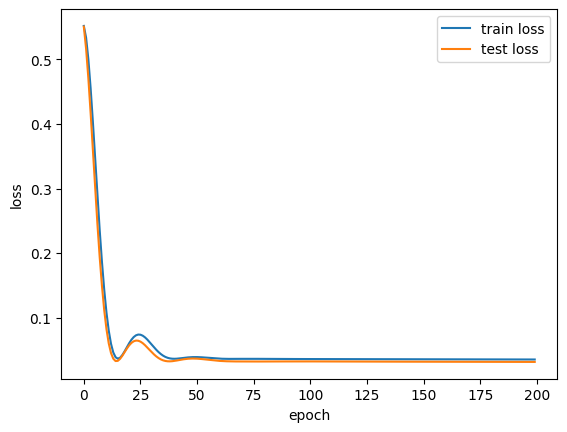

In [19]:
plt.plot(losses)
plt.plot(test_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'test loss'])

In [20]:
torch.save(model.state_dict(), 'weights/fpnn.pt')
fpnn = model

In [21]:
X_max = X_scaler.data_max_.copy()
X_min = X_scaler.data_min_.copy()

In [22]:
X_end = X_max.copy()
tmp = X_min.copy()
tmp[1:] = 0
print(tmp)

X_start = X_end - tmp

print(X_end)
print(X_start)

X_original = np.linspace(X_start, X_end, 50)
X_scaled = X_scaler.transform(X_original)

[639.51183214   0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
[1.80220431e+05 1.00000000e+02 3.52599525e+01 7.05616443e+01
 9.59400000e+01 7.75370026e+01 9.19570007e+01 2.89389979e+06
 5.45550003e+01 4.87960477e+08]
[1.79580919e+05 1.00000000e+02 3.52599525e+01 7.05616443e+01
 9.59400000e+01 7.75370026e+01 9.19570007e+01 2.89389979e+06
 5.45550003e+01 4.87960477e+08]


In [23]:
y_out = model(torch.Tensor(X_scaled).to(device))

In [24]:
print(y_out.shape)

torch.Size([50, 7])


In [25]:
X_plot = X_original
y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

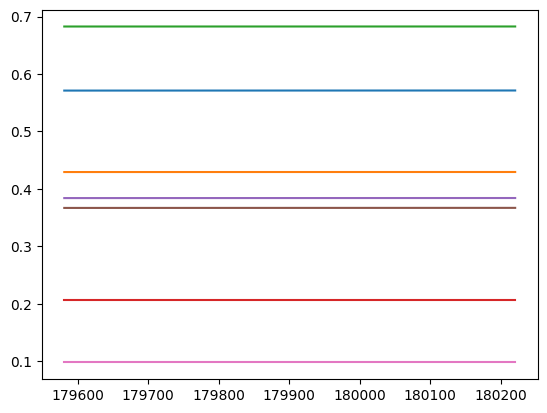

In [26]:
plt.plot(X_plot[:,0], y_plot[:, 0])
plt.plot(X_plot[:,0], y_plot[:, 1])
plt.plot(X_plot[:,0], y_plot[:, 2])
plt.plot(X_plot[:,0], y_plot[:, 3])
plt.plot(X_plot[:,0], y_plot[:, 4])
plt.plot(X_plot[:,0], y_plot[:, 5])
plt.plot(X_plot[:,0], y_plot[:, 6])

In [27]:
X, Y = split_X_Y(train)
X_columns = X.columns
y_columns = Y.columns



In [28]:
from math import ceil
def one2many(X, Y, X_scaler=X_scaler, Y_scaler=Y_scaler):
    # for each factors in sgd data, there will be two values in side in array form
    # eg:
    # res = [[X_plot, Y_plot], ..., [X_plot, Y_plot]]
    res = []

    X_max = X_scaler.data_max_.copy()
    X_min = X_scaler.data_min_.copy()

    for i in range(X.shape[1]):
        X_end = X_max.copy()
        tmp = X_min.copy()
        tmp[i+1:] = 0

        X_start = X_end - tmp

        X_original = np.linspace(X_start, X_end, 50)
        X_scaled = X_scaler.transform(X_original)

        y_out = model(torch.Tensor(X_scaled).to(device))

        X_plot = X_scaled
        y_plot = Y_scaler.transform(y_out.cpu().detach().numpy())

        res.append([X_plot[:, i], y_plot])
    
    return res

# data is in form one2many returns
def plotDiff(data, x_labels, y_labels, n_cols=3, figure_size=(3, 3)):
    n_rows = ceil(len(y_labels) / n_cols)
    figure, axis = plt.subplots(n_rows, n_cols)

    figure.set_size_inches(figure_size)
    figure.tight_layout(pad=5.0)

    for i in range(len(y_labels)):
        row = i // n_cols
        col = i % n_cols

        for j in range(len(x_labels)):
            X2plot = data[j][0]
            Y2plot = data[j][1]
            axis[row, col].plot(X2plot, Y2plot[:, i])

            axis[row, col].set_xlabel('value of sgd factors')
            axis[row, col].set_ylabel(y_labels[i])

    
    for i in range(len(y_labels), n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        axis[row, col].axis('off')
    
    figure.legend(x_labels, loc='lower right')
    return figure

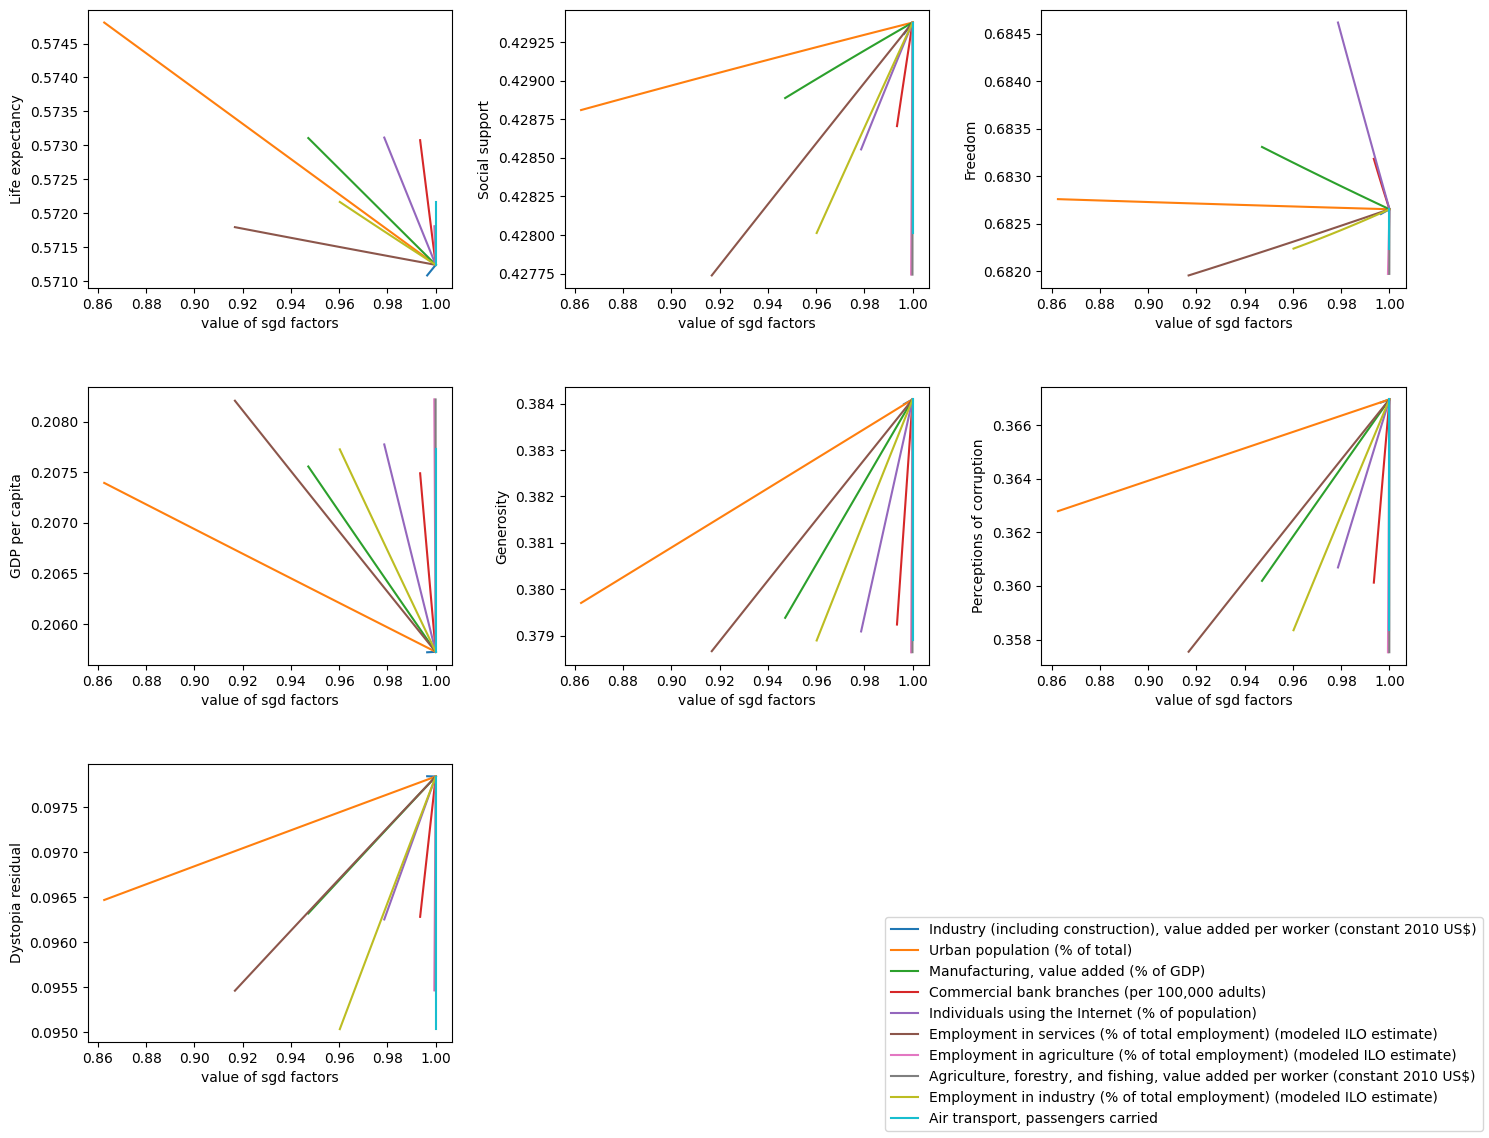

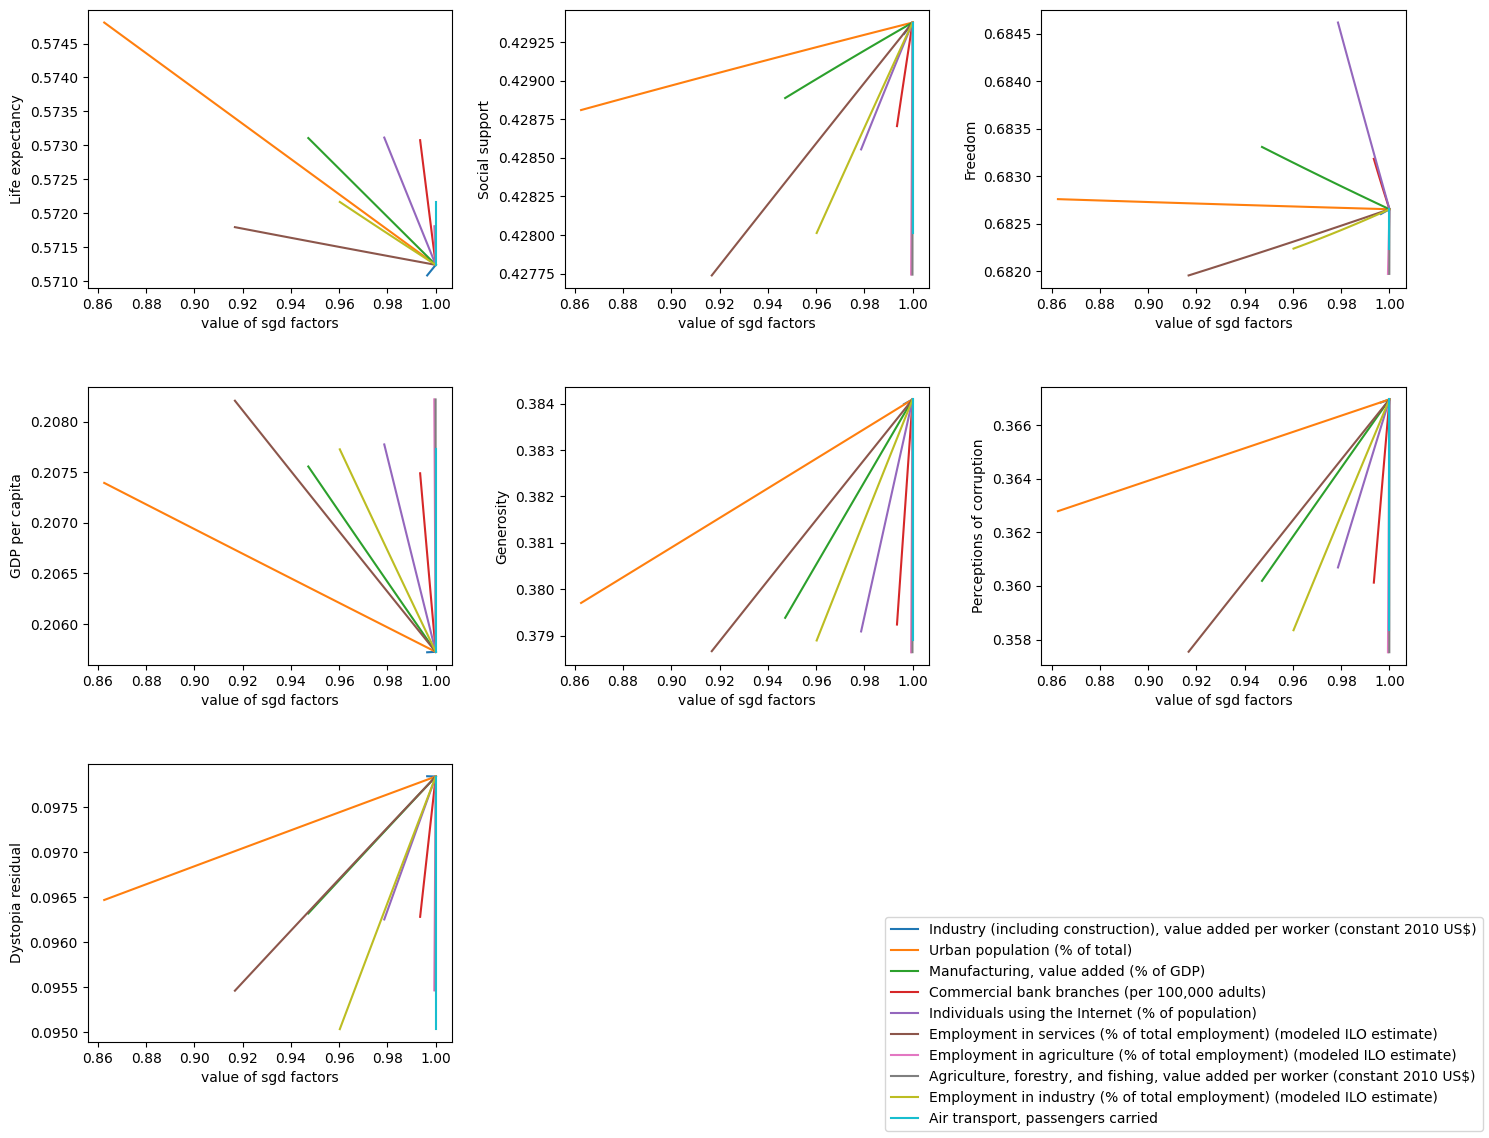

In [29]:
res = one2many(X, Y)
plotDiff(res, X_columns, y_columns, figure_size=(15, 12))

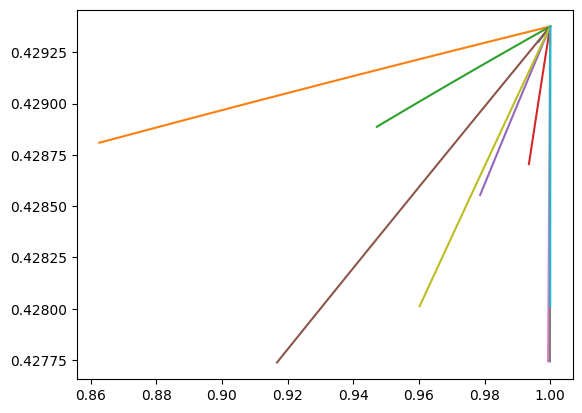

In [30]:
for i in range(len(X_columns)):
    X2plot = res[i][0]
    Y2plot = res[i][1]

    plt.plot(X2plot, Y2plot[:, 1])

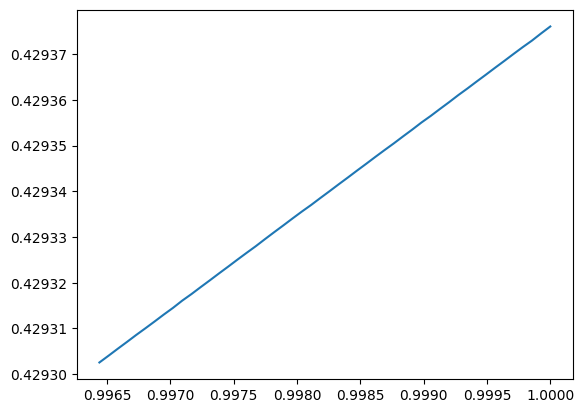

In [31]:
plt.plot(res[0][0], res[0][1][:, 1])

## Happiness Score model

In [32]:
wh_df = pd.read_csv('tmp/wh_all.csv')
print(wh_df.isna().sum().sum())
wh_df_numeric= wh_df.drop(['Country', 'Country code', 'Year', 'Happiness rank'], axis=1)
wh_df_numeric.head()

0


,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual
0,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100
1,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580
2,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801
3,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000
4,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,1.792000


In [33]:
train, test = train_test_split(wh_df_numeric, test_size=0.1)
print(train.shape)
print(test.shape)

(635, 8)
(71, 8)


In [34]:
from sklearn.preprocessing import PolynomialFeatures
def transform(data):
    X_origin = data.drop('Happiness score', axis=1).to_numpy()
    poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly_transformer.fit_transform(X_origin)
    return X_poly, data['Happiness score'].to_numpy().reshape((-1, 1)), poly_transformer

In [35]:
X_train, y_train, poly_transformer = transform(train)
print(X_train.shape)
print(y_train.shape)

(635, 35)
(635, 1)


In [36]:
from sklearn.linear_model import LinearRegression

poly_model = LinearRegression()
poly_model.fit(X_train, y_train)

LinearRegression()

In [37]:
X_test, y_test, _ = transform(test)
y_preds = poly_model.predict(X_test)

In [38]:
from sklearn.metrics import mean_squared_error

mae = mean_squared_error(y_test, y_preds)
print(mae)

5.6254040336310456e-08


In [39]:
X_max = wh_df_numeric.iloc[:, 1:].max().to_numpy()
X_min = wh_df_numeric.iloc[:, 1:].min().to_numpy()

In [40]:
tmp = X_max.copy()
tmp[0] = X_min[0]

X_in = np.linspace(tmp, X_max, 50)
X_poly = poly_transformer.transform(X_in)
print(X_in.shape)
print(X_poly.shape)

preds = poly_model.predict(X_poly)
print(preds.shape)

(50, 7)
(50, 35)
(50, 1)


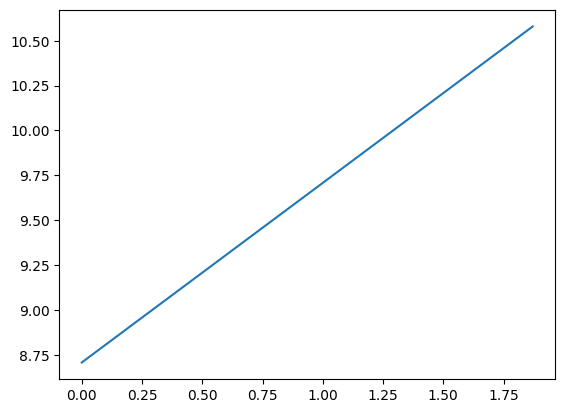

In [41]:
plt.plot(X_in[:, 0], preds[:, 0])

## Urbanization indicators modeling

In [42]:
developed_countries = pd.read_csv(f'./dataset/developed_countries.csv')
developed_countries['Country code'] = get3countryCode(developed_countries['Country'])

In [43]:
sgd = pd.read_csv('./dataset/world_happiness/sustainable_develop_goals/sdg-csv-zip-7-mb-/SDGData.csv')
sgd_urban = sgd[sgd['Indicator Name'].isin(
    URBANIZATION_INDICATORS + ANTI_URBANIZATION_INDICATORS
)].iloc[:, :32].sort_values(by=['Country Name', 'Indicator Name']).reset_index(drop=True)
print(sgd_urban.shape)
sgd_urban

(5260, 32)


,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,587.874492,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,16.334516,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
def nanBeforeTarget(df_tmp):
    # df_tmp = sgd_urban.iloc[0:20, 0:16]
    h, w = df_tmp.shape
    for i in range(h):
        if not pd.isna(df_tmp.iloc[i, w-1]) and pd.isna(df_tmp.iloc[i, w-2]):
            return True
            

In [45]:
# for the last one, we take it as output of the sequence
valid_dfs = []
WINDOW_SIZE = 15 + 1
for i in range(0, 5260, 20):
    for j in range(0, sgd_urban.shape[1]-4-WINDOW_SIZE):
        df_tmp = sgd_urban.iloc[i:i+20, j+4:j+WINDOW_SIZE+4]
        if nanBeforeTarget(df_tmp):
            continue
            
        valid_dfs.append(df_tmp)

    #     break
    # break

In [46]:
def rename_df2merge(df):
    columns = df.columns
    mapping_dict = {}
    for i in range(WINDOW_SIZE-1):
        mapping_dict[columns[i]] = 'x_' + str(i)
    
    mapping_dict[columns[-1]] = 'y'

    df = df.rename(columns=mapping_dict)
    return df

# rename_df2merge(df_tmp)

In [47]:
for i in range(len(valid_dfs)):
    valid_dfs[i] = rename_df2merge(valid_dfs[i])

In [48]:
### time series data preparing
row = sgd_urban.iloc[4, :]
def impute_row(row):
    row_numeric = row.iloc[4:].to_numpy()

    row_numeric.shape

    i = 0
    while i < row_numeric.shape[0] and np.isnan(row_numeric[i]):
        row_numeric[i] = 0
        i += 1

    j = i + 1

    while i < row_numeric.shape[0]:
        while i < row_numeric.shape[0] and not np.isnan(row_numeric[i]):
            i += 1

        if i == row_numeric.shape[0]:
            break
        
        j = i
        i -= 1 

        while j < row_numeric.shape[0] and np.isnan(row_numeric[j]):
            j += 1
        
        # means all the values behind index i is null
        if j == row_numeric.shape[0]:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i]
        else:
            for index in range(i+1, j):
                row_numeric[index] = row_numeric[i] + (row_numeric[j] - row_numeric[i]) * (index-i) / (j-i)
    
    row.iloc[4:] = row_numeric
    row = row.fillna(0)

    return row

impute_row(row)

/home/chan/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/chan/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


Country Name                                            Afghanistan
Country Code                                                    AFG
Indicator Name    Annual freshwater withdrawals, industry (% of ...
Indicator Code                                       ER.H2O.FWIN.ZS
1990                                                              0
1991                                                              0
1992                                                              0
1993                                                              0
1994                                                              0
1995                                                              0
1996                                                              0
1997                                                              0
1998                                                              0
1999                                                              0
2000                                            

In [49]:
sgd_imputed = sgd_urban #.apply(impute_row, axis=1)
sgd_imputed

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,587.874492,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,16.334516,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_countries = []
h, w = sgd_imputed.shape
for i in range(0, h, 20):
    df_country = sgd_imputed.iloc[i:i+20, 4:].to_numpy()
    df_countries.append(df_country)

sgd_countries = np.concatenate(df_countries, axis=1)
sgd_countries.shape

(20, 7364)

In [51]:
from sklearn.preprocessing import StandardScaler
sgd_scaler = StandardScaler()
sgd_scaler.fit(sgd_countries.T)

StandardScaler()

In [108]:
df_sgd_scaler = sgd_urban.iloc[:20, [2]]
df_sgd_scaler['mean'] = sgd_scaler.mean_
df_sgd_scaler['var'] = sgd_scaler.var_
df_sgd_scaler

,Indicator Name,mean,var
0,"Agriculture, forestry, and fishing, value adde...",1.229037e+04,2.514486e+09
1,"Air transport, freight (million ton-km)",5.076387e+03,3.105928e+08
2,"Air transport, passengers carried",8.231440e+07,7.754687e+16
3,"Annual freshwater withdrawals, agriculture (% ...",5.016086e+01,1.139462e+03
4,"Annual freshwater withdrawals, industry (% of ...",2.253529e+01,7.356202e+02
5,CO2 emissions (metric tons per capita),4.646036e+00,3.812829e+01
6,"Commercial bank branches (per 100,000 adults)",1.732739e+01,4.930693e+02
7,"Educational attainment, competed at least Bach...",1.609056e+01,7.900855e+01
8,"Educational attainment, competed at least Mast...",6.057455e+00,3.352584e+01
9,Employment in agriculture (% of total employme...,3.130637e+01,5.765900e+02


In [52]:
valid_nps = []
for i in range(len(valid_dfs)):
    df_tmp = valid_dfs[i] 
    df_tmp = df_tmp.apply(impute_row, axis=1)
    np_tmp = df_tmp.to_numpy()
    np_tmp_scaled = sgd_scaler.transform(np_tmp.T).T
    valid_nps.append(np_tmp_scaled)


In [53]:
print(len(valid_nps))
valid_nps[0].shape

2598


(20, 16)

In [54]:
sgd_ts_data = np.concatenate(valid_nps)
sgd_ts_data.shape

(51960, 16)

In [55]:
print(sgd_imputed['Country Code'].unique())

['AFG' 'ALB' 'DZA' 'ASM' 'AND' 'AGO' 'ATG' 'ARB' 'ARG' 'ARM' 'ABW' 'AUS'
 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL' 'BLZ' 'BEN' 'BMU' 'BTN'
 'BOL' 'BIH' 'BWA' 'BRA' 'VGB' 'BRN' 'BGR' 'BFA' 'BDI' 'CPV' 'KHM' 'CMR'
 'CAN' 'CSS' 'CYM' 'CAF' 'CEB' 'TCD' 'CHI' 'CHL' 'CHN' 'COL' 'COM' 'COD'
 'COG' 'CRI' 'CIV' 'HRV' 'CUB' 'CUW' 'CYP' 'CZE' 'DNK' 'DJI' 'DMA' 'DOM'
 'EAR' 'EAS' 'TEA' 'EAP' 'ECU' 'EGY' 'SLV' 'GNQ' 'ERI' 'EST' 'SWZ' 'ETH'
 'EMU' 'ECS' 'TEC' 'ECA' 'EUU' 'FRO' 'FJI' 'FIN' 'FCS' 'FRA' 'PYF' 'GAB'
 'GMB' 'GEO' 'DEU' 'GHA' 'GIB' 'GRC' 'GRL' 'GRD' 'GUM' 'GTM' 'GIN' 'GNB'
 'GUY' 'HTI' 'HPC' 'HIC' 'HND' 'HKG' 'HUN' 'IBD' 'IBT' 'IDB' 'IDX' 'IDA'
 'ISL' 'IND' 'IDN' 'IRN' 'IRQ' 'IRL' 'IMN' 'ISR' 'ITA' 'JAM' 'JPN' 'JOR'
 'KAZ' 'KEN' 'KIR' 'PRK' 'KOR' 'XKX' 'KWT' 'KGZ' 'LAO' 'LTE' 'LCN' 'TLA'
 'LAC' 'LVA' 'LDC' 'LBN' 'LSO' 'LBR' 'LBY' 'LIE' 'LTU' 'LMY' 'LIC' 'LMC'
 'LUX' 'MAC' 'MDG' 'MWI' 'MYS' 'MDV' 'MLI' 'MLT' 'MHL' 'MRT' 'MUS' 'MEX'
 'FSM' 'MEA' 'TMN' 'MNA' 'MIC' 'MDA' 'MCO' 'MNG' 'M

In [56]:
sgd_imputed

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,587.874492,919.727932,9.150535e+02,8.850408e+02,1.137182e+03,1.084252e+03,1.028653e+03,9.213596e+02,9.308000e+02,9.285927e+02
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,1.080195e+02,1.094211e+02,1.166607e+02,8.462122e+01,3.428347e+01,3.310204e+01,2.901088e+01,2.514421e+01
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,1.999127e+06,2.279341e+06,1.737962e+06,2.044188e+06,2.209428e+06,1.929907e+06,1.917924e+06,1.858558e+06
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,16.334516,11.030513,9.208113e+00,9.172401e+00,1.404340e+01,1.291906e+01,1.259076e+01,1.188860e+01,1.159602e+01,1.101701e+01
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# indicators_ranges = {}
indicators_ranges = []

indicatorsInOrder = sgd_imputed.iloc[:20, :]['Indicator Name'].to_list()

for indicator in indicatorsInOrder:
    indicator_max = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].max().max()
    indicator_min = sgd_imputed[sgd_imputed['Indicator Name'] == indicator].iloc[:, 4:].min().min()
    indicators_ranges.append([indicator_max, indicator_min])

# ordered ranges
print(indicators_ranges)

indicators_ranges = np.array(indicators_ranges)
print(indicators_ranges)

# for key in indicators_ranges.keys():
#     print(key)


[[2893899.78724209, 136.686608242829], [213590.250597765, 0.0], [3978849402.0, 0.0], [99.7, 0.0], [96.22, 0.0], [70.1356414419537, 0.0107325415714037], [287.237593801076, 0.132079633452601], [36.94929, 0.0], [28.15081, 0.0], [92.556999206543, 0.0590000003576279], [59.576000213623, 1.7039999961853], [88.0230026245117, 5.2979998588562], [1204.56084972227, 0.0], [98.87143552, 0.0], [449726.019218809, 191.355276262938], [56.6507007273372, 0.0], [88.0369961490474, 0.248761270209143], [2702736.0, 0.675], [1149835.0, 0.068], [100.0, 5.416]]
[[2.89389979e+06 1.36686608e+02]
 [2.13590251e+05 0.00000000e+00]
 [3.97884940e+09 0.00000000e+00]
 [9.97000000e+01 0.00000000e+00]
 [9.62200000e+01 0.00000000e+00]
 [7.01356414e+01 1.07325416e-02]
 [2.87237594e+02 1.32079633e-01]
 [3.69492900e+01 0.00000000e+00]
 [2.81508100e+01 0.00000000e+00]
 [9.25569992e+01 5.90000004e-02]
 [5.95760002e+01 1.70400000e+00]
 [8.80230026e+01 5.29799986e+00]
 [1.20456085e+03 0.00000000e+00]
 [9.88714355e+01 0.00000000e+00

In [58]:
ipnn_indicators = list(sgd_urban.iloc[:20, :]['Indicator Name'])
print(ipnn_indicators)

['Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)', 'Air transport, freight (million ton-km)', 'Air transport, passengers carried', 'Annual freshwater withdrawals, agriculture (% of total freshwater withdrawal)', 'Annual freshwater withdrawals, industry (% of total freshwater withdrawal)', 'CO2 emissions (metric tons per capita)', 'Commercial bank branches (per 100,000 adults)', "Educational attainment, competed at least Bachelor's or equivalent, population 25+, total (%) (cumulative)", "Educational attainment, competed at least Master's or equivalent, population 25+, total (%) (cumulative)", 'Employment in agriculture (% of total employment) (modeled ILO estimate)', 'Employment in industry (% of total employment) (modeled ILO estimate)', 'Employment in services (% of total employment) (modeled ILO estimate)', 'Forest area (% of land area)', 'Individuals using the Internet (% of population)', 'Industry (including construction), value added per worker (con

In [59]:
## Model - encoder and decoder manner
import torch.nn as nn
class IndicatorPredictNN(nn.Module):
    def __init__(self, indicators_dim, hidden_size, rnn_hidden, batch_size, rnn_layers=2) -> None:
        super().__init__()

        self.batch_size = batch_size
        self.rnn_layers = rnn_layers
        self.rnn_hidden = rnn_hidden

        self.linear = nn.Linear(indicators_dim, hidden_size)
        # self.act1 = nn.Sigmoid()
        # self.linear2 = nn.Linear(hidden_size, hidden_size*4)
        # self.act2 = nn.Sigmoid()
        self.rnn = nn.LSTM(hidden_size, rnn_hidden, rnn_layers, batch_first=True)
        # self.act3 = nn.Sigmoid()
        # self.linear4 = nn.Linear(rnn_hidden, hidden_size)
        # self.act4 = nn.Sigmoid()
        self.linear5 = nn.Linear(rnn_hidden, indicators_dim)

    
    def init_hidden(indicators_dim, hidden_dim):
        pass
    
    def forward(self, x):
        out = self.linear(x)
        # out = self.act1(out)
        # out = self.linear2(out)
        # out = self.act2(out)

        h0, c0 = self.init_hidden(self.batch_size, self.rnn_layers, self.rnn_hidden)
        out, _ = self.rnn(out, (h0, c0))

        # out = self.act3(out)
        # out = self.linear4(out[:, -1, :])
        # out = self.act4(out)
        out = self.linear5(out[:, -1, :])

        return out


    def init_hidden(self, batch_size, rnn_layers, rnn_hidden, bidirection=False, device=torch.device("cuda")):
        h0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        c0 = torch.randn((1+bidirection)*rnn_layers, batch_size, rnn_hidden, device=device)
        return h0, c0
        
        

In [60]:
indicators_dim = sgd_imputed['Indicator Name'].unique().shape[0]
indicators_dim

20

In [61]:
afg = sgd_imputed.iloc[:20, :]
col = afg.iloc[0:, 4:6].to_numpy(dtype=np.float32)
col
X = torch.Tensor(col).T
X.shape

torch.Size([2, 20])

In [62]:
device = torch.device('cuda')

In [63]:
# data = sgd_rescaled.iloc[:, 4:].to_numpy()
data = sgd_ts_data
# data = data.T
# data = data.reshape((263, 20, 28))
samples_len = data.shape[0] // 20
data = data.reshape(samples_len, 20, WINDOW_SIZE)
data = data.transpose((0, 2, 1))
data.shape

(2598, 16, 20)

In [64]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.1)
print(train.shape)
print(test.shape)

(2338, 16, 20)
(260, 16, 20)


In [65]:
model = IndicatorPredictNN(indicators_dim, indicators_dim*3, 40, 10)
model.to(device)

n_epochs = 2000
lr = 0.01

# criterion = nn.CrossEntropyLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [66]:
train.shape
X = train[0:10, :WINDOW_SIZE-1, :]
y = train[0:10, WINDOW_SIZE-1, :]
print(X.shape)

(10, 15, 20)


In [67]:
losses = []
test_losses = []
for epoch in range(1, n_epochs):
    optimizer.zero_grad()
    loss_total = 0

    for i in range(21):
        X = torch.Tensor(train[i*10:(i+1)*10, :WINDOW_SIZE-1, :]).to(device)
        y = torch.Tensor(train[i*10:(i+1)*10, WINDOW_SIZE-1, :]).to(device)

        # print(X.shape)

        out = model(X)
        loss = criterion(out, y)

        loss.backward()

        loss_total += loss.item()
    
    optimizer.step()

    loss_total_test = 0
    for i in range(test.shape[0] // 10):
        start = i*10
        end = (i+1)*10
        if end > test.shape[0]:
            start = end - 10
        
        X_test = torch.Tensor(test[start:end, :WINDOW_SIZE-1, :]).to(device)
        y_test = torch.Tensor(test[start:end, WINDOW_SIZE-1, :]).to(device)

        out = model(X_test)
        loss = criterion(out, y_test)

        loss_total_test += loss.item()


    losses.append(loss_total)
    test_losses.append(loss_total_test)
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss_total))

Epoch: 10/2000............. Loss: 8.5874
Epoch: 20/2000............. Loss: 6.9628
Epoch: 30/2000............. Loss: 5.8073
Epoch: 40/2000............. Loss: 5.1218
Epoch: 50/2000............. Loss: 4.6317
Epoch: 60/2000............. Loss: 4.2464
Epoch: 70/2000............. Loss: 3.8129
Epoch: 80/2000............. Loss: 3.5442
Epoch: 90/2000............. Loss: 3.2626
Epoch: 100/2000............. Loss: 3.0137
Epoch: 110/2000............. Loss: 2.7883
Epoch: 120/2000............. Loss: 2.5616
Epoch: 130/2000............. Loss: 2.3878
Epoch: 140/2000............. Loss: 2.1609
Epoch: 150/2000............. Loss: 2.0230
Epoch: 160/2000............. Loss: 1.8989
Epoch: 170/2000............. Loss: 1.6733
Epoch: 180/2000............. Loss: 1.5802
Epoch: 190/2000............. Loss: 1.5003
Epoch: 200/2000............. Loss: 1.4318
Epoch: 210/2000............. Loss: 1.3907
Epoch: 220/2000............. Loss: 1.3375
Epoch: 230/2000............. Loss: 1.2357
Epoch: 240/2000............. Loss: 1.1907
E

Text(0.5, 1.0, 'overall')

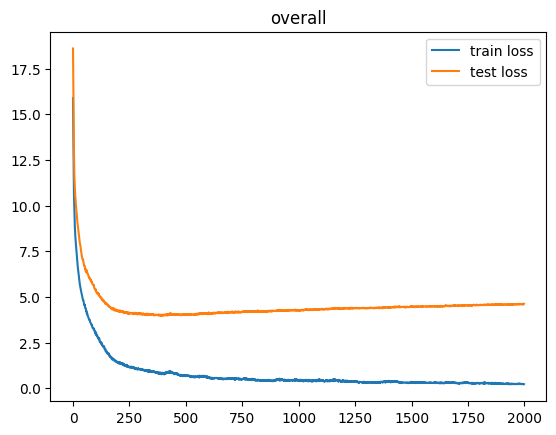

In [68]:

# total loss
import matplotlib.pyplot as plt

plt.plot(losses)
plt.plot(test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('overall')

Text(0.5, 1.0, 'single')

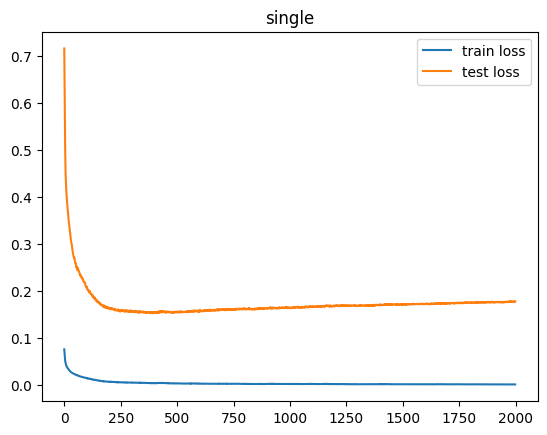

In [69]:
single_losses = np.array(losses) / 210
single_test_losses = np.array(test_losses) / (test.shape[0] // 10)

plt.plot(single_losses)
plt.plot(single_test_losses)
plt.legend(['train loss', 'test loss'])
plt.title('single')

In [70]:
torch.save(model.state_dict(), 'weights/ipnn.pt')
ipnn = model

In [71]:
fpnn_idx_in_ipnn = []
for index_name in fpnn_input_columns:
    fpnn_idx_in_ipnn.append(ipnn_indicators.index(index_name))  
    

print(fpnn_idx_in_ipnn)

[14, 19, 15, 6, 13, 11, 9, 0, 10, 2]


In [72]:
num_countries = 10

nation_numeric = sgd_imputed.iloc[:20*num_countries, 4:].to_numpy()
nation_numeric.shape

for i in range(0, 20*num_countries, 20):
    tmp = nation_numeric[i:i+20, :]
    tmp = sgd_scaler.transform(tmp.T).T
    nation_numeric[i:i+20, :] = tmp

nation_numeric.shape
nation_numeric = nation_numeric.reshape(10, 20, 28)
nation_numeric = nation_numeric.transpose((0, 2, 1))
nation_numeric_tensor = torch.Tensor(nation_numeric).to(device)
nation_numeric_tensor.shape

torch.Size([10, 28, 20])

In [73]:
preds = model(nation_numeric_tensor)
preds.shape

torch.Size([10, 20])

In [74]:
def onestep(X):
    y = model(X) 
    return y

In [75]:
y = onestep(nation_numeric_tensor).reshape(10, 1, 20)
print(y.shape)

torch.Size([10, 1, 20])


In [76]:
print(nation_numeric_tensor.shape)
print(y.shape)

torch.Size([10, 28, 20])
torch.Size([10, 1, 20])


In [77]:
X1 = torch.concat([nation_numeric_tensor, y], 1)
X1.shape
y1 = onestep(X1)
y1.shape

torch.Size([10, 20])

In [78]:
def getNextNYear(n, X):
    for i in range(n):
        y = model(X).reshape(10, 1, 20)
        X = torch.concat((X, y), 1)
    
    return X[:, -n:, :]

In [79]:
from math import ceil

years = 15

nations_total = sgd_imputed.shape[0] // 20


nextYears = []

for i in range(ceil(nations_total/10)):
    start = i*10*20
    end = (i+1)*10*20

    if end > sgd_imputed.shape[0]:
        end = sgd_imputed.shape[0]
        start = end - 10*20

    nation_numeric = sgd_imputed.iloc[start:end, 4:].to_numpy()

    # print(nation_numeric.shape)

    # print(end, start)

    for j in range(0, end-start, 20):
        tmp = nation_numeric[j:j+20, :]
        tmp = sgd_scaler.transform(tmp.T).T
        nation_numeric[j:j+20, :] = tmp

    nation_numeric = nation_numeric.reshape(10, 20, 28)
    nation_numeric = nation_numeric.transpose([0, 2, 1])

    X = torch.Tensor(nation_numeric).to(device)
    X_next10 = getNextNYear(years, X)

    nextYears.append({
        "start": start,
        "end": end,
        "preds": X_next10.cpu().detach().numpy()
    })
    

In [80]:
print(len(nextYears))
print(nextYears[-1]['preds'].shape)

27
(10, 15, 20)


In [81]:
tmp = nextYears[-1]['preds']
tmp.shape

(10, 15, 20)

In [82]:
sgd_imputed.shape

(5260, 32)

In [83]:
newCols = []
for i in range(2019, 2019+years):
    newCols.append(str(i))

sgd_preds = sgd_imputed.iloc[:, :4]
sgd_preds = sgd_preds.reindex(columns=list(sgd_preds.columns) + newCols)
sgd_preds

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
for item in nextYears:
    start = item['start']
    end = item['end']
    preds = item['preds']
    preds = preds.transpose([0, 2, 1])
    preds = preds.reshape((end-start), years)
    sgd_preds.iloc[start:end, 4:] = preds

In [85]:
sgd_preds

,Country Name,Country Code,Indicator Name,Indicator Code,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
sgd_preds_scaled_back = sgd_preds.iloc[:, :4]
sgd_preds_scaled_back = sgd_preds_scaled_back.reindex(columns=list(sgd_preds_scaled_back.columns) + newCols)
sgd_preds_scaled_back

h, w = sgd_preds.shape
for i in range(0, h, 20):
    tmp = sgd_preds.iloc[i:i+20, 4:]
    tmp = sgd_scaler.inverse_transform(tmp.T).T
    sgd_preds_scaled_back.iloc[i:i+20, 4:] = tmp
    

In [87]:
sgd_preds_and_old = pd.merge(sgd_imputed, sgd_preds_scaled_back, how='inner', on=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
sgd_preds_and_old

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,"Air transport, freight (million ton-km)",IS.AIR.GOOD.MT.K1,9.400000,8.400000,8.400000,6.700000,12.300000,12.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,AFG,"Annual freshwater withdrawals, agriculture (% ...",ER.H2O.FWAG.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Annual freshwater withdrawals, industry (% of ...",ER.H2O.FWIN.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5255,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5256,Zimbabwe,ZWE,Medium and high-tech industry (% manufacturing...,NV.MNF.TECH.ZS.UN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5257,Zimbabwe,ZWE,"Railways, goods transported (million ton-km)",IS.RRS.GOOD.MT.K6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5258,Zimbabwe,ZWE,"Railways, passengers carried (million passenge...",IS.RRS.PASG.KM,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [628]:
from math import ceil

def plotIndicators(country):
    sgd_country = sgd_preds_and_old[sgd_preds_and_old['Country Code'] == country]
    sgd_country

    col_per_row = 5

    fig, ax = plt.subplots(ceil(sgd_country.shape[0] / col_per_row), col_per_row)

    fig.set_size_inches(24, 12)
    fig.tight_layout(pad=2.0)

    for i in range(sgd_country.shape[0]):
        index = sgd_country['Indicator Name'].iloc[i]
        indicator_values = sgd_country[sgd_country['Indicator Name'] == index].iloc[:, 4:].to_numpy().reshape(-1, 1)

        old = indicator_values[:27]
        new = indicator_values[27:]
        old_ranges = range(1990, 1990+27)
        new_ranges = range(1990+27, 1990+indicator_values.shape[0])

        row = i // col_per_row
        col = i % col_per_row
        ax[row, col].plot(old_ranges, old)
        ax[row, col].plot(new_ranges, new, color='orange')
        ax[row, col].title.set_text(index[:10])


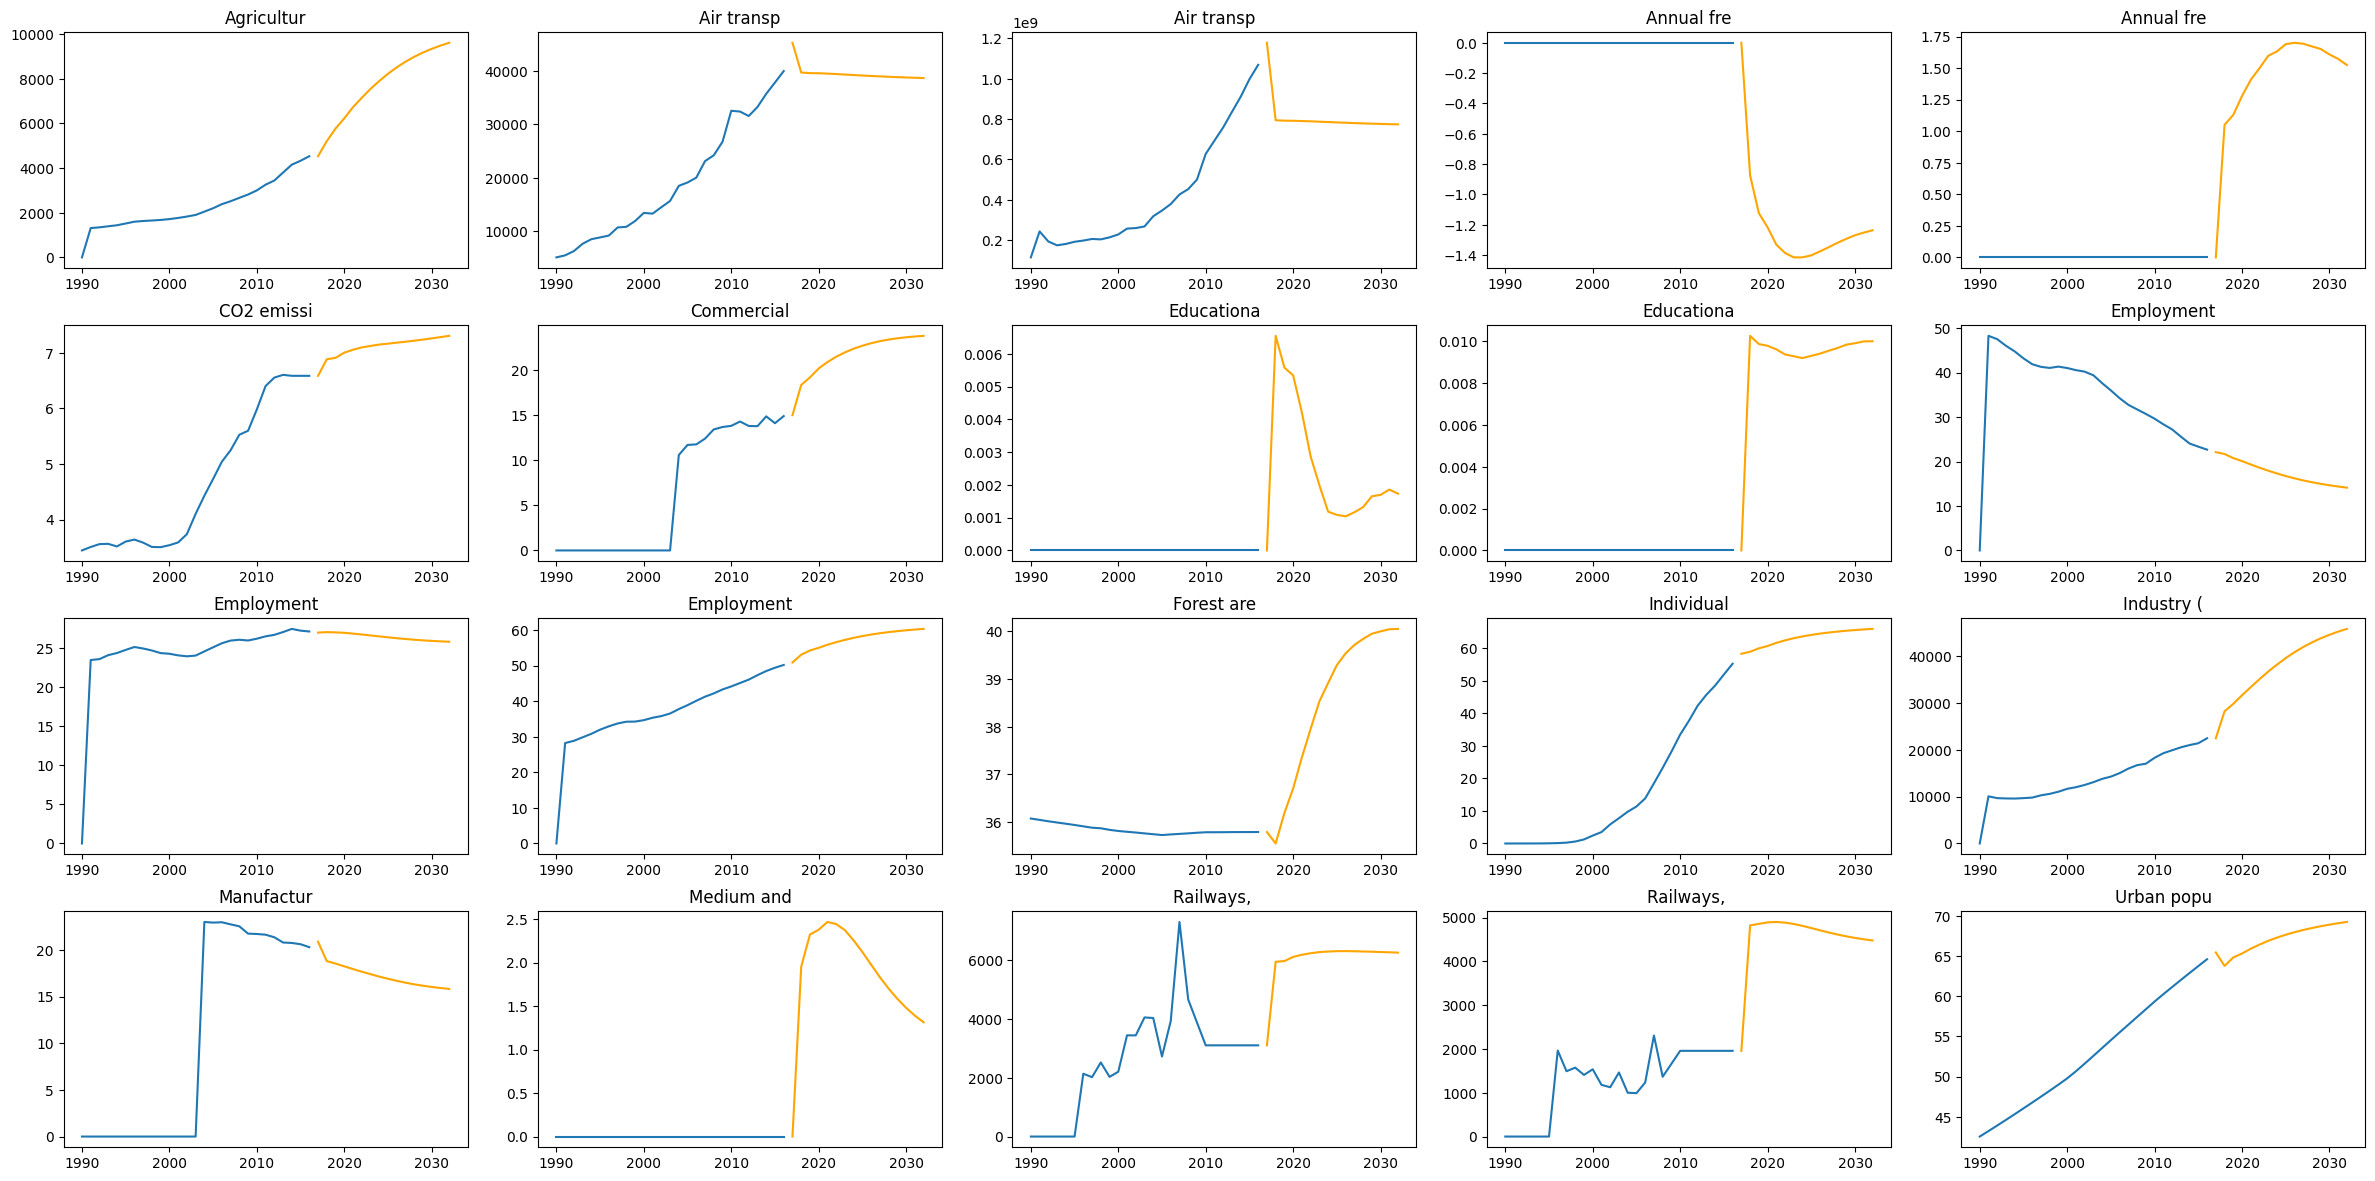

In [629]:
plotIndicators('UMC')

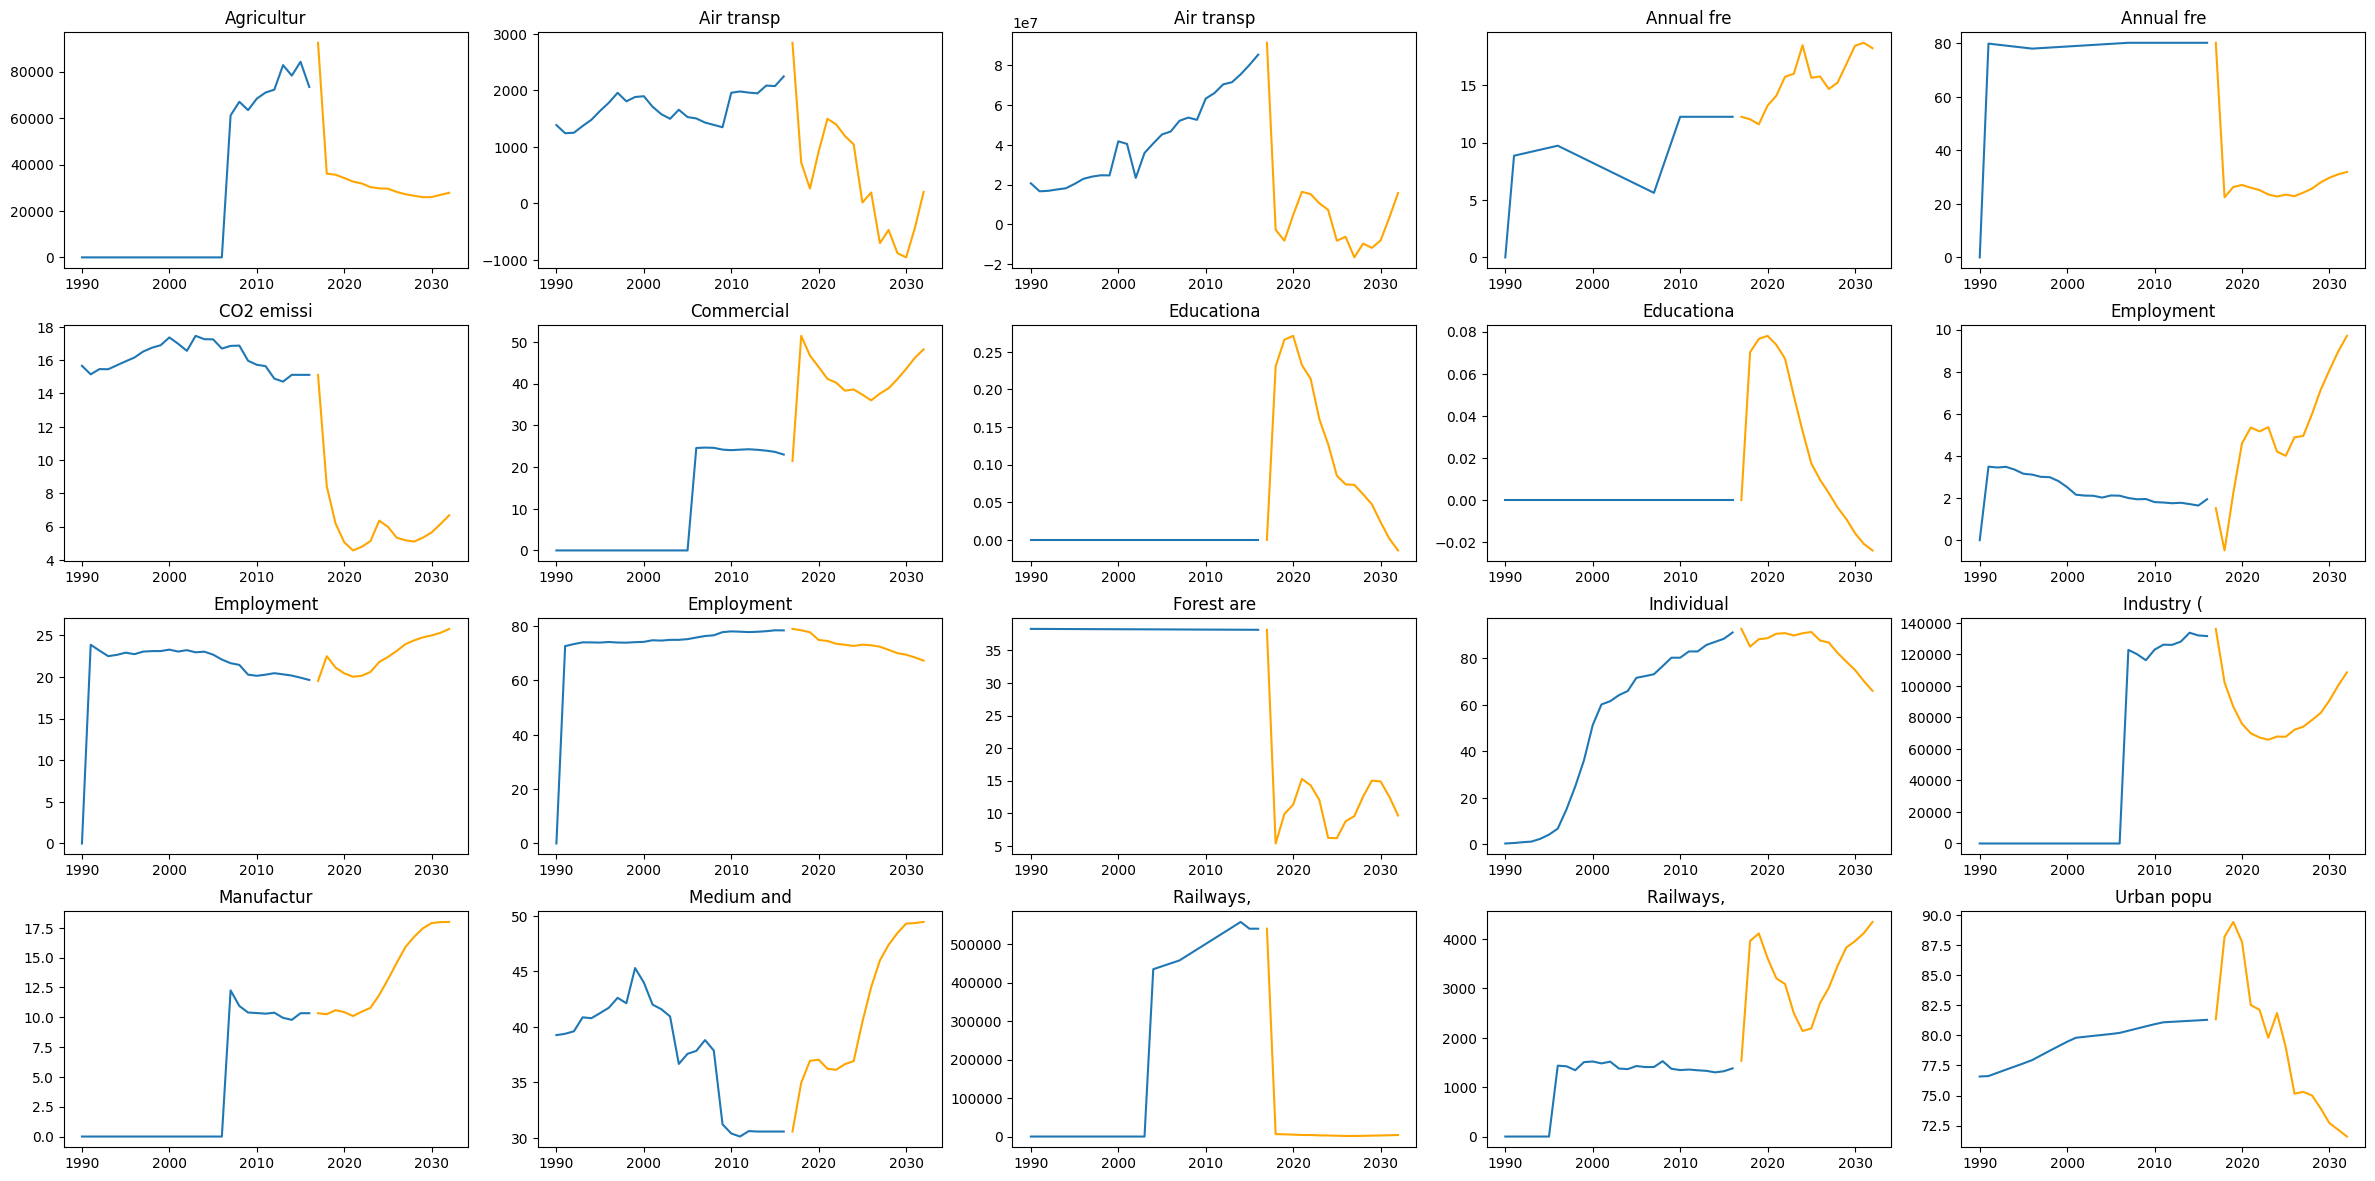

In [630]:
plotIndicators('CAN')

In [631]:
fpnn_df = sgd_preds_and_old[sgd_preds_and_old['Indicator Name'].isin(fpnn_input_columns)].reset_index(drop=True)
fpnn_df

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033
0,Afghanistan,AFG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.EMPL.KD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.810828e+03,-4.671529e+03,-6.034574e+03,-5.414652e+03,-2.654479e+03,-1.079394e+03,-4.880072e+02,6.571000e+02,1.092198e+03,1.333780e+03
1,Afghanistan,AFG,"Air transport, passengers carried",IS.AIR.PSGR,241400.000000,212300.000000,212300.000000,197000.000000,238400.000000,250400.000000,...,1.173659e+07,1.656304e+07,3.710710e+07,6.443772e+07,8.160326e+07,7.861691e+07,6.364242e+07,5.113289e+07,4.977646e+07,4.643742e+07
2,Afghanistan,AFG,"Commercial bank branches (per 100,000 adults)",FB.CBK.BRCH.P5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7.995175e+00,7.928054e+00,7.189750e+00,6.021631e+00,3.358053e+00,1.310741e+00,1.254736e+00,1.320000e+00,6.536811e-02,4.613416e-02
3,Afghanistan,AFG,Employment in agriculture (% of total employme...,SL.AGR.EMPL.ZS,0.000000,57.661999,58.313999,63.848000,68.803001,63.202000,...,4.660673e+01,5.199716e+01,5.631140e+01,5.594135e+01,5.338643e+01,5.251470e+01,5.093418e+01,4.779179e+01,4.525874e+01,4.490804e+01
4,Afghanistan,AFG,Employment in industry (% of total employment)...,SL.IND.EMPL.ZS,0.000000,14.214000,13.332000,10.282000,7.806000,10.500000,...,2.284437e+01,1.920613e+01,1.590036e+01,1.448736e+01,1.462302e+01,1.478365e+01,1.478729e+01,1.570848e+01,1.702343e+01,1.716285e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2625,Zimbabwe,ZWE,Employment in services (% of total employment)...,SL.SRV.EMPL.ZS,0.000000,26.938000,26.815001,26.958000,27.052999,27.795000,...,3.268160e+01,3.545224e+01,3.583587e+01,3.538951e+01,3.448259e+01,3.259175e+01,3.020594e+01,2.770334e+01,2.600511e+01,2.517827e+01
2626,Zimbabwe,ZWE,Individuals using the Internet (% of population),IT.NET.USER.ZS,0.000000,0.000435,0.000870,0.001304,0.001739,0.007684,...,-3.453387e+00,4.442407e-01,3.273547e+00,1.304062e+00,-6.291495e-01,2.174454e+00,8.556692e+00,1.336745e+01,1.525493e+01,1.476404e+01
2627,Zimbabwe,ZWE,"Industry (including construction), value added...",NV.IND.EMPL.KD,0.000000,4931.097951,4609.560170,4571.428413,5131.848425,4713.987228,...,-1.689102e+04,-7.904344e+03,-1.821423e+03,1.522680e+03,3.496229e+03,5.558646e+03,7.020374e+03,6.879874e+03,6.691364e+03,8.025977e+03
2628,Zimbabwe,ZWE,"Manufacturing, value added (% of GDP)",NV.IND.MANF.ZS,20.484785,24.096142,26.898699,21.021162,19.054827,19.264222,...,1.635297e+01,1.591786e+01,1.455998e+01,1.321139e+01,1.221329e+01,1.140969e+01,1.068715e+01,9.999760e+00,9.634921e+00,9.520479e+00


In [632]:
fpnn_input_columns

Index(['Employment in agriculture (% of total employment) (modeled ILO estimate)',
       'Individuals using the Internet (% of population)',
       'Air transport, passengers carried',
       'Commercial bank branches (per 100,000 adults)',
       'Industry (including construction), value added per worker (constant 2010 US$)',
       'Employment in services (% of total employment) (modeled ILO estimate)',
       'Agriculture, forestry, and fishing, value added per worker (constant 2010 US$)',
       'Manufacturing, value added (% of GDP)',
       'Employment in industry (% of total employment) (modeled ILO estimate)',
       'Urban population (% of total)'],
      dtype='object')

In [633]:
current_order = fpnn_df.iloc[:10, :]['Indicator Name'].to_list()
wanted_order = list(fpnn_input_columns)
current_order
wanted_order

cur2wanted_mapping = []
for idx in wanted_order:
    cur2wanted_mapping.append(current_order.index(idx)) 

print(cur2wanted_mapping)

[3, 6, 1, 2, 7, 5, 0, 8, 4, 9]


In [634]:
def getCountryWHPredictedFeatures(countryCode):
    country_code = countryCode
    country_data = fpnn_df[fpnn_df['Country Code'] == country_code].reset_index(drop=True)
    country_data_reordered = country_data.iloc[cur2wanted_mapping, :]
    idx2iter = country_data_reordered.columns[4:]
    idx2iter

    fpnn_preds = {}

    for idx in list(idx2iter):
        raw = country_data_reordered.loc[:, idx].to_numpy()
        scaled = X_scaler.transform(raw.reshape(1, 10))
        X = torch.Tensor(scaled).to(device)
        y = fpnn(X).cpu().detach().numpy()

        y = Y_scaler.inverse_transform(y)
        fpnn_preds[idx] = y
    
    return fpnn_preds


In [635]:
def getHappinessScore(X):
    X_poly = poly_transformer.transform(X)
    y = poly_model.predict(X_poly)
    return y

In [636]:
wh_df

,Country,Year,Happiness rank,Happiness score,GDP per capita,Social support,Life expectancy,Freedom,Perceptions of corruption,Generosity,Dystopia residual,Country code
0,Afghanistan,2015,153,3.575,0.319820,0.302850,0.303350,0.23414,0.097190,0.365100,1.952100,AFG
1,Afghanistan,2016,154,3.360,0.382270,0.110370,0.173440,0.16430,0.071120,0.312680,2.145580,AFG
2,Afghanistan,2017,141,3.794,0.401477,0.581543,0.180747,0.10618,0.061158,0.311871,2.150801,AFG
3,Afghanistan,2018,145,3.632,0.332000,0.537000,0.255000,0.08500,0.036000,0.191000,2.196000,AFG
4,Afghanistan,2019,154,3.203,0.350000,0.517000,0.361000,0.00000,0.025000,0.158000,1.792000,AFG
...,...,...,...,...,...,...,...,...,...,...,...,...
701,United Kingdom,2017,19,6.714,1.441634,1.496460,0.805336,0.50819,0.265428,0.492774,1.704144,ZWE
702,United Kingdom,2018,11,7.190,1.244000,1.433000,0.888000,0.46400,0.082000,0.262000,2.817000,ZWE
703,United Kingdom,2019,15,7.054,1.333000,1.538000,0.996000,0.45000,0.278000,0.348000,2.111000,ZWE
704,United States,2015,15,7.119,1.394510,1.247110,0.861790,0.54604,0.158900,0.401050,2.510110,ZWE


In [637]:
wh_df = pd.read_csv('tmp/wh_all.csv')

In [638]:
tmp = getCountryWHPredictedFeatures('CAN')
tmp

{'1990': array([[0.17815055, 0.12428591, 1.9612794 , 0.54000425, 0.776164  ,
         0.37318864, 0.97109497]], dtype=float32),
 '1991': array([[0.23565577, 0.10495739, 2.0964992 , 0.5196851 , 0.7921785 ,
         0.38093388, 0.99208844]], dtype=float32),
 '1992': array([[0.2350584 , 0.10522628, 2.0973907 , 0.51992846, 0.7924074 ,
         0.38115165, 0.99271184]], dtype=float32),
 '1993': array([[0.23445815, 0.10550074, 2.098266  , 0.5201521 , 0.7925556 ,
         0.38133943, 0.99318   ]], dtype=float32),
 '1994': array([[0.23449482, 0.10538954, 2.0979636 , 0.52044684, 0.79357105,
         0.3814185 , 0.99400985]], dtype=float32),
 '1995': array([[0.23462956, 0.10522884, 2.0977292 , 0.52086943, 0.79516447,
         0.38154623, 0.99512184]], dtype=float32),
 '1996': array([[0.23421253, 0.10523094, 2.0976753 , 0.5215593 , 0.7973849 ,
         0.3819021 , 0.99682415]], dtype=float32),
 '1997': array([[0.2333565 , 0.10479757, 2.0949974 , 0.5234949 , 0.80442774,
         0.38291603, 1.0022

In [639]:
tmp.keys()

dict_keys(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2019', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', '2031', '2032', '2033'])

In [640]:
def plotHappiness(countryCode):
    country = countryCode
    can_wh_preds = getCountryWHPredictedFeatures(country)
    old = wh_df[wh_df['Country code'] == country]['Happiness score'].to_numpy()[:-1]
    
    old_ranges = range(2015, 2019)
    new = []
    new_ranges = [year for year in range(2019, 2034)]
        
    for idx in new_ranges:
        new.append(getHappinessScore(can_wh_preds[str(idx)])[0][0]) 
    

    if len(old) > 0: 
        new_ranges.insert(0, 2018)
        new.insert(0, old[-1])


    # whc = np.array(whc)
    # print(whc.shape)
    # print(whc_old.shape)

    # whc2plot = np.concatenate((whc_old, whc))
    # x = [str(year) for year in range(2015, 2015 + len(whc2plot))]


    plt.figure(figsize=(12, 6))
    if len(old) > 0: plt.plot(old_ranges,old)
    plt.plot(new_ranges, new, color='orange')
    plt.xlabel('date')
    plt.ylabel('happiness score')
    plt.title(f'{country} happiness scores')

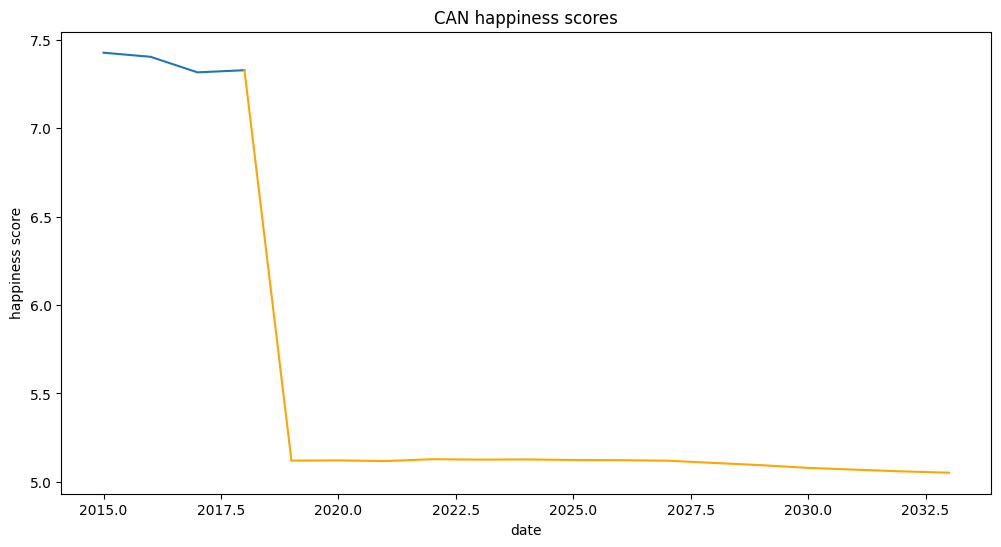

In [641]:
plotHappiness('CAN')

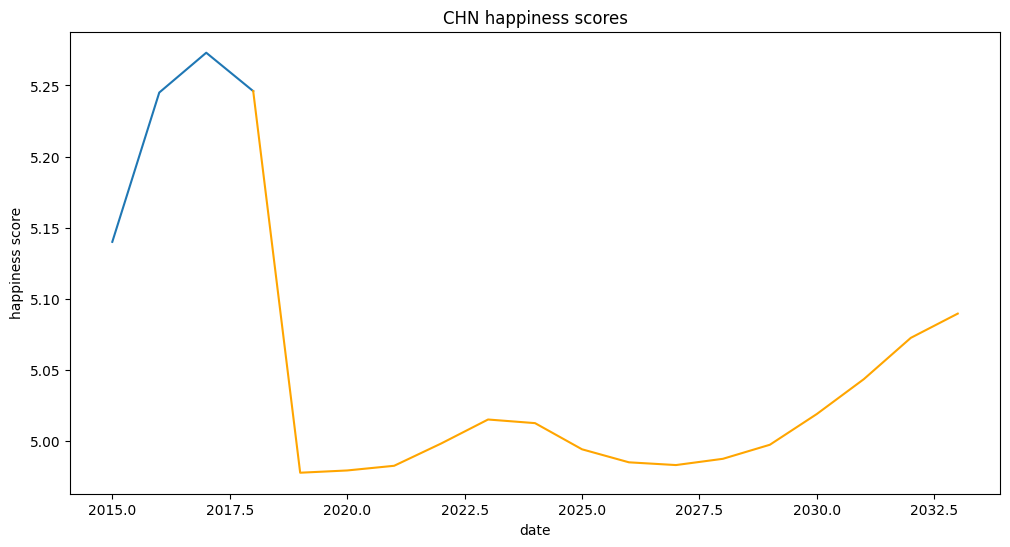

In [642]:
plotHappiness('CHN')

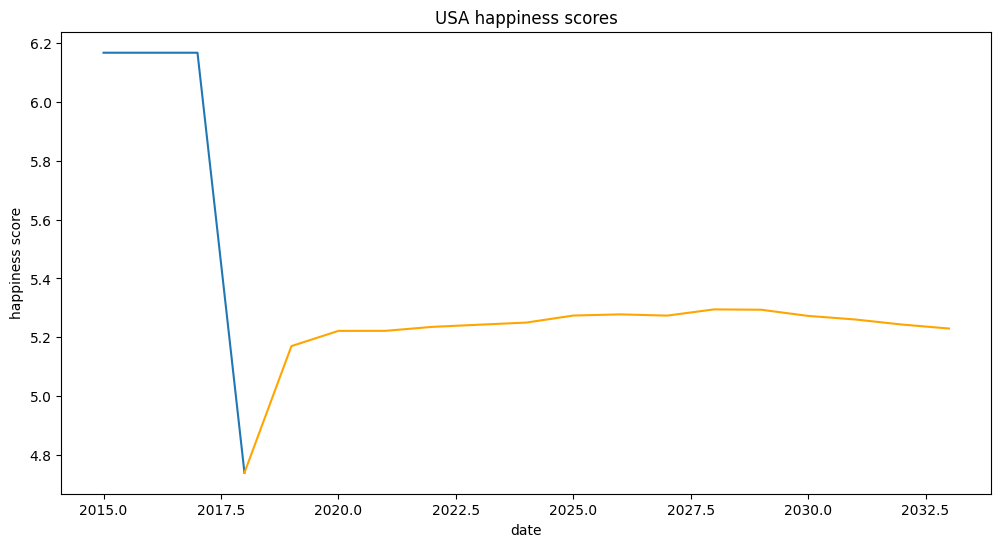

In [643]:
plotHappiness('USA')

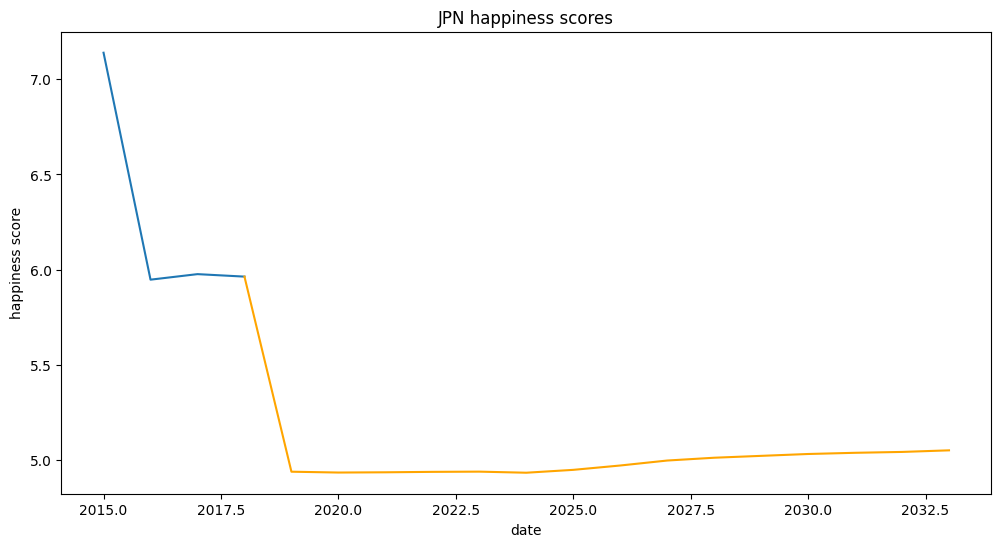

In [644]:
plotHappiness('JPN')

## Make some plots

In [ ]:
for i in range(1, 1):
    print(i)

In [ ]:
t = torch.Tensor(col.T)
t

tensor([[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00, 2.1345e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.0678e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1177e+01],
        [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00, 1.8767e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01, 1.4214e+01, 2.8124e+01,
         2.0678e+00, 4.2932e-04, 0.0000e+00, 0.0000e+00, 1.3591e+01, 0.0000e+00,
         0.0000e+00, 2.1266e+01]])

In [ ]:
t.reshape((1, 2, 20))

tensor([[[0.0000e+00, 9.4000e+00, 2.4140e+05, 0.0000e+00, 0.0000e+00,
          2.1345e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 2.0678e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1177e+01],
         [0.0000e+00, 8.4000e+00, 2.1230e+05, 0.0000e+00, 0.0000e+00,
          1.8767e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7662e+01,
          1.4214e+01, 2.8124e+01, 2.0678e+00, 4.2932e-04, 0.0000e+00,
          0.0000e+00, 1.3591e+01, 0.0000e+00, 0.0000e+00, 2.1266e+01]]])